# PennFudan을 위한 사용자 정의 데이터 세트

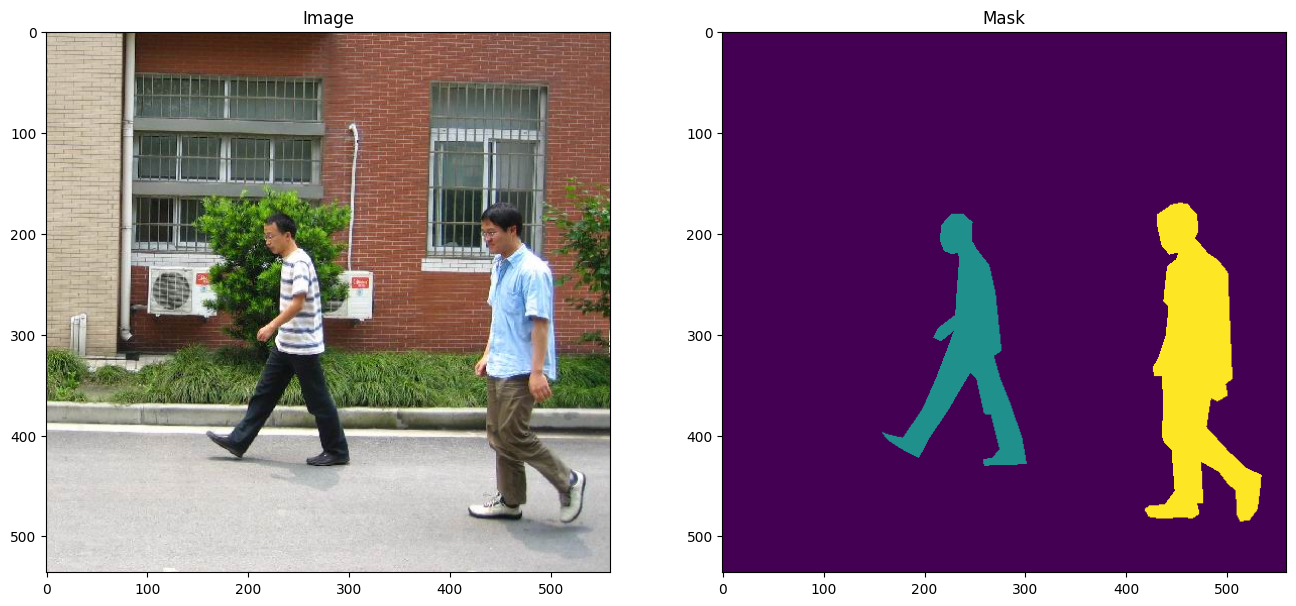

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("C:\\Users\\SVT\\Desktop\\PyTorch\\data\\PennFudanPed\\PNGImages\\FudanPed00001.png")
mask = read_image("C:\\Users\\SVT\\Desktop\\PyTorch\\data\\PennFudanPed\\PedMasks\\FudanPed00001_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

- 각 이미지는 해당 분할 마스크가 있으며, 각 색상은 다른 인스턴스에 해당

In [2]:
import os 
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennduanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sortiong them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    
    # __getitem__ : (image, target) 튜플 반환,
    # image는 [채널C, 높이H, 너비W] 텐서 (0~1) 또는 PIL, target은 딕셔너리
    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances ard encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color- encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and target into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)




## 모델 정의
- Faster R-CNN 을 기반으로 하는 Mask R-CNN을 사용
    - Faster R-CNN은 이미지 내 잠재적 객체에 대한 경계 상자와 클래스 점수를 모두 예측하는 모델

1. 사전 학습된 모델에서의 미세 조정
    - COOC로 사전 학습된 모델을 기반으로 특정 클래스에 맞춰 미세 조정을 수행

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2 # 1 class (person) + background(0) << K+1
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replacethe pre0-trained head with a mew one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

2. 다른 백본을 추가하기 위해 모델 수정

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ''FasterRCNN'' needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. we have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ''OrderedDict[Tensor]'', and in ''featmap_names'' you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model= FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\SVT/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100.0%


3. PennFudan 데이터셋을 위한 객체 감지 및 인스턴스 분할 모델

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained in COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

In [8]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

1

**데이터 증강/변환 함수**

In [9]:
from torchvision.transforms import v2 as ToTensor

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

4. 테스트 forward() 방법 (선택사항)

In [12]:
import sys
sys.path.append('.')  # 현재 디렉토리를 파이썬 경로에 추가

from engine import train_one_epoch, evaluate
import utils


ModuleNotFoundError: No module named 'engine'